In [1]:
#importing required nltk libraries
import nltk
from nltk import sent_tokenize
import pandas as pd

In [2]:
# loading our corpus Negative Reviews
import os
os.getcwd()
test_set = pd.read_csv(r'C:\\Users\\HP\\OneDrive\\Desktop\\Grad School\\IST718 Big Data\\Semester Project\\Scotch_Reviews.csv')
print(test_set[:150])

                                            Responses:
0    Single cask Aberfeldy bottlings are very few a...
1    From a sherry cask. Bright and lively. Quite f...
2    Similar in flavor to the Aberfeldy 12 reviewed...
3    A prime component in Dewar’s blended scotch. T...
4    Independent releases of the Perthshire single ...
..                                                 ...
145  A peculiar Auchentoshan. The Bordeaux wine dom...
146  This whisky comes from two bourbon casks, prod...
147  Poor old Auchroisk. Not only couldn’t anyone p...
148  The original Singleton, seemingly discarded as...
149  Here is Auchroisk at its more lifted and clean...

[150 rows x 1 columns]


In [3]:
#using the Airline Services dataset for training on sentiment polarity
train_dataset = pd.read_csv(r'C:\\Users\\HP\\OneDrive\\Desktop\\Grad School\\IST 664 NLP\\train_tweets_airlines1.csv')
print(train_dataset[:150])

         tweet_id airline_sentiment  airline_sentiment_confidence  \
0    5.703060e+17           neutral                        1.0000   
1    5.703010e+17          positive                        0.3486   
2    5.703010e+17           neutral                        0.6837   
3    5.703010e+17          negative                        1.0000   
4    5.703010e+17          negative                        1.0000   
..            ...               ...                           ...   
145  5.696100e+17          negative                        1.0000   
146  5.696080e+17          negative                        0.6790   
147  5.696000e+17          positive                        1.0000   
148  5.695960e+17          positive                        1.0000   
149  5.695960e+17          negative                        1.0000   

              negativereason  negativereason_confidence         airline  \
0                        NaN                        NaN  Virgin America   
1                    

In [4]:
#displaying the dataset using pandas
display(len(train_dataset))

8456

In [5]:
#Since this is social media data, we will have to add a few extra preprocessing steps
# First, let's remove  @ and # (Twitter platform affordances) from the training data
# We'll use regular expressions for that, creating a Function that we can use to pass the data through
# NOTE: you could add more regexes to clean noisy characters such as emoticons, numbers, etc
def remove_at(x):
    x = str(x).replace('@', '')
    x = str(x).replace('#', '')
    return x

In [6]:
#applying the clearning function and visualizing the result
train_dataset['text'] = train_dataset['text'].apply(lambda x: remove_at(x))
display(len(train_dataset))

8456

In [7]:
train_dataset['text'] = train_dataset['text'].apply(lambda x: remove_at(x))
display(len(train_dataset))

8456

In [8]:
display(train_dataset['text'].head(5))

0                    VirginAmerica What dhepburn said.
1    VirginAmerica plus you've added commercials to...
2    VirginAmerica I didn't today... Must mean I ne...
3    VirginAmerica it's really aggressive to blast ...
4    VirginAmerica and it's a really big bad thing ...
Name: text, dtype: object

In [9]:
# tokenizing using RegexTokenizer for tokenizing using specific regular expressions
# in our case, we eliminate Twitter's noise by picking up only alphabets and numbers
# indicated by the 'w', the regex alias for 'word'
   
import nltk
    
tokenizer = nltk.RegexpTokenizer('\\w+')
doc = train_dataset['text'].apply(lambda x : tokenizer.tokenize(x))
display(len(doc))

8456

In [10]:
display(doc.head(5))

0                [VirginAmerica, What, dhepburn, said]
1    [VirginAmerica, plus, you, ve, added, commerci...
2    [VirginAmerica, I, didn, t, today, Must, mean,...
3    [VirginAmerica, it, s, really, aggressive, to,...
4    [VirginAmerica, and, it, s, a, really, big, ba...
Name: text, dtype: object

In [11]:
#EXPLORATORY ANAYSIS
#Checking if the dataset is balanced
#extracting types of labels from the 'airline_sentiment' column in the dataset
PosSentences = train_dataset[train_dataset['airline_sentiment'] == 'positive']
NegSentences = train_dataset[train_dataset['airline_sentiment'] == 'negative']
NeuSentences = train_dataset[train_dataset['airline_sentiment'] == 'neutral']

In [12]:
#grouping all labels to find out the count for each group
label_groups = train_dataset.groupby('airline_sentiment').size().reset_index(name='counts')
display(label_groups.head(5))

,airline_sentiment,counts
0,negative,2994
1,neutral,3099
2,positive,2363


In [13]:
#Visualizing label group data within training dataset
# NOTE that the dataset is unbalanced
# please come up with strategies to balance this dataset
# if not, explain how that affect your results
# if using unbalanced dataset, please provide MicroAverage evaluation scores from your classifier
   
import matplotlib.pyplot as plt
import seaborn as sns

<function matplotlib.pyplot.show(close=None, block=None)>

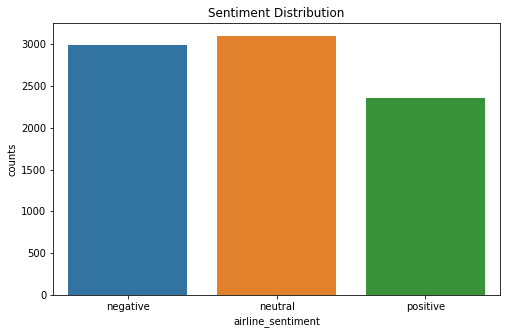

In [14]:
plt.figure(figsize=(8,5))
ax = sns.barplot(x="airline_sentiment", y="counts", data=label_groups)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title(label="Sentiment Distribution")
plt.show

In [15]:
#BEGGINING TO WORK ON THE CLASSIFICATION TASK
# extracting the tweet message and its asigned sentiment label
# we do this by creating a Python list
# our list will have the tweet's tokens and corresponding sentiments
   
# opening a list to store our data
docs = []

In [16]:
# iterating over the dataset and extracting the information sought
for i in range(0, len(train_dataset['airline_sentiment'])):
    # appending the info to the list
    docs.append((doc[i], train_dataset['airline_sentiment'][i]))

In [17]:
#printing the output for validation
docs[0]

(['VirginAmerica', 'What', 'dhepburn', 'said'], 'neutral')

In [18]:
# The dataset is sorted by sentiment label
# so we need to randomize it to avoid sampling biases 
   
#importing the random library
import random

In [19]:
#shuffling the documents
random.shuffle(docs)

In [20]:
#defining set of words that will be used for features
#we'll find the 2000 most common words and used them as an important feature of the whole corpus
   
all_words = [word for (sentance,category) in docs for word in sentance]
top_words = nltk.FreqDist(all_words)
most_common_words = top_words.most_common(2000)
word_features = [word for (word,count) in most_common_words]

In [21]:
#checking if we have the 2000 words we need
len(set(all_words))

13306

In [22]:
######################now we will use that list of most frequent words in the entire corpus
#to iterate over each sentence and check if any of those words are present
#in that way, we will see if this unigram corpus feature is present on that particular sentence
#using Boolean logic that matches values and returns 'True' or 'False'
#we do this by defining a Python \"function,\" i.e.a piece of code writen to be reused
def document_features(document, word_features):
    document_words = set(document)
    #we open a Pytnon dictionary instead of a list
    features = {}
    for word in word_features:
    #checking if the word from word_features matches a word in the document
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [23]:
#now we apply the function to the document dataset
featuresets = [(document_features(d, word_features), c) for (d, c) in docs]
   
#we print the list of features matches for the first document ([0]) in the corpus
#we'll see a Python dictionary with the key being the feature word
#and the value being 'True' or 'False' according to that word being matched in the present document or not
#we'll se a lot of 'False' values because (of course) not all 2000 words will be on each sentence!
featuresets[0]

({'contains(to)': False,
  'contains(united)': False,
  'contains(I)': False,
  'contains(the)': False,
  'contains(you)': False,
  'contains(a)': True,
  'contains(for)': False,
  'contains(t)': False,
  'contains(on)': False,
  'contains(and)': True,
  'contains(my)': False,
  'contains(flight)': True,
  'contains(in)': False,
  'contains(SouthwestAir)': True,
  'contains(JetBlue)': False,
  'contains(is)': False,
  'contains(it)': False,
  'contains(of)': False,
  'contains(me)': False,
  'contains(co)': False,
  'contains(s)': False,
  'contains(http)': False,
  'contains(AmericanAir)': False,
  'contains(that)': False,
  'contains(with)': True,
  'contains(have)': False,
  'contains(your)': False,
  'contains(was)': False,
  'contains(at)': False,
  'contains(can)': False,
  'contains(from)': False,
  'contains(USAirways)': False,
  'contains(be)': False,
  'contains(this)': False,
  'contains(get)': False,
  'contains(not)': False,
  'contains(are)': True,
  'contains(but)': Fals

In [24]:
#checking the length of the list of features
len(featuresets)

8456

In [25]:
#We are ready now to do machine learning using the unigram list we just created
#we use a Naive Bayes classifier with 5-fold cross validation for training on sentiments using unigrams

import numpy as np
from sklearn.model_selection import KFold

In [26]:
kf = KFold(n_splits = 5)
sum = 0

for train, test in kf.split(featuresets):
    train_data = np.array(featuresets)[train]
    test_data = np.array(featuresets)[test]
    classifier = nltk.NaiveBayesClassifier.train(train_data)
    sum += nltk.classify.accuracy(classifier, test_data)

#storing the score in a variable 
acc1 = sum/5

In [27]:
#let's see the accuracy score for this unigram classifier

acc1

0.7712851936199572

In [28]:
#We will now create a new feature: bigrams
#we'll use the code we already know from class labs 

from nltk.collocations import *
import re

In [29]:
#data cleaning and preprocessing
stopwords = nltk.corpus.stopwords.words('english')

def alpha(w):
    pattern = re.compile('^[^a-z]+$')
    if(pattern.match(w)):
        return True
    else:
        return False

In [30]:
#creating bigrams features for the corpus and applying cleaning steps
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_words)
finder.apply_word_filter(alpha)
finder.apply_word_filter(lambda w: w in stopwords)
scored = finder.score_ngrams(bigram_measures.raw_freq)
scored[:10]

[(('customer', 'service'), 0.0016738218465266446),
 (('Cancelled', 'Flightled'), 0.0010715261193245884),
 (('JetBlue', 'Our'), 0.0008194023265423322),
 (('Late', 'Flight'), 0.0008194023265423322),
 (('Our', 'fleet'), 0.0008123988878539363),
 (('fleek', 'http'), 0.0008053954491655402),
 (('united', 'thanks'), 0.0005742819724484722),
 (('Booking', 'Problems'), 0.0005672785337600762),
 (('Cancelled', 'Flighted'), 0.00046222695343413616),
 (('Thanks', 'united'), 0.0004342131986805521)]

In [31]:
#extracting clean bigrams (no frequency information)
bigram_features = [bigram for (bigram, count) in scored[:2000]]

#printing the first 30 for confirmation
bigram_features[:30]

[('customer', 'service'),
 ('Cancelled', 'Flightled'),
 ('JetBlue', 'Our'),
 ('Late', 'Flight'),
 ('Our', 'fleet'),
 ('fleek', 'http'),
 ('united', 'thanks'),
 ('Booking', 'Problems'),
 ('Cancelled', 'Flighted'),
 ('Thanks', 'united'),
 ('Flight', 'Booking'),
 ('JetBlue', 'thanks'),
 ('Late', 'Flightr'),
 ('Cancelled', 'Flight'),
 ('united', 'yes'),
 ('united', 'thank'),
 ('AmericanAir', 'thanks'),
 ('united', 'flight'),
 ('flight', 'united'),
 ('united', 'Thanks'),
 ('thanks', 'united'),
 ('SouthwestAir', 'thanks'),
 ('first', 'class'),
 ('SouthwestAir', 'Thanks'),
 ('USAirways', 'thanks'),
 ('connecting', 'flight'),
 ('service', 'united'),
 ('flight', 'attendant'),
 ('help', 'united'),
 ('JetBlue', 'thank')]

In [32]:
#after finding all bigrams of the corpus (i.e. the bigram feature of the corpus)
#we create a function that checks if those feature bigrams are present on each specific document
#exactly as we did with unigrams\n",

def bi_document_features(document, bigram_features):
    document_words = list(nltk.bigrams(document))
    features = {}
    for word in bigram_features:
        #boolean logic will retunt 'True' if there is a match, or 'False' if not
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [33]:
#applying the function to our documents
featuresets2 = [(bi_document_features(d, bigram_features), c) for (d, c) in docs]

#seeing the featureset for the first document
featuresets2[0]

({"contains(('customer', 'service'))": False,
  "contains(('Cancelled', 'Flightled'))": False,
  "contains(('JetBlue', 'Our'))": False,
  "contains(('Late', 'Flight'))": False,
  "contains(('Our', 'fleet'))": False,
  "contains(('fleek', 'http'))": False,
  "contains(('united', 'thanks'))": False,
  "contains(('Booking', 'Problems'))": False,
  "contains(('Cancelled', 'Flighted'))": False,
  "contains(('Thanks', 'united'))": False,
  "contains(('Flight', 'Booking'))": False,
  "contains(('JetBlue', 'thanks'))": False,
  "contains(('Late', 'Flightr'))": False,
  "contains(('Cancelled', 'Flight'))": False,
  "contains(('united', 'yes'))": False,
  "contains(('united', 'thank'))": False,
  "contains(('AmericanAir', 'thanks'))": False,
  "contains(('united', 'flight'))": False,
  "contains(('flight', 'united'))": False,
  "contains(('united', 'Thanks'))": False,
  "contains(('thanks', 'united'))": False,
  "contains(('SouthwestAir', 'thanks'))": False,
  "contains(('first', 'class'))": Fal

In [34]:
#checking the length of the featureset
#it should be the same than unigram, because we processed number of documents
#this is for verification
len(featuresets2)

8456

In [35]:
#how we run the classifier to see if we get a good accuracy score
#all this is just to find out which feature is more informative to predict sentiment
#Naive Bayes classifier with 5-fold cross validation for training on sentiments using bigram features

kf = KFold(n_splits = 5)
sum = 0

for train, test in kf.split(featuresets2):
    train_data2 = np.array(featuresets2)[train]
    test_data2 = np.array(featuresets2)[test]
    classifier2 = nltk.NaiveBayesClassifier.train(train_data2)
    sum += nltk.classify.accuracy(classifier2, test_data2)

acc2 = sum/5

In [36]:
#accuracy of classifier2, bigrams

acc2

0.5774611942239055

In [37]:
#Since the accuracy for unigrams is higher than bigrams, we'll use unigrams
#as a feature to train the classifier and pass the test set through it
#the test set is the negative review dataset, whose reviews we want to predict sentiment

In [38]:
# determining the sentiments of the 1/4th of the comments using classifier1
# for debugging purposes, we use only 1/100 of the corpus
# but for the final experiment you should use at least 1/4 of it
# NOTE: WITH 1/4 OF THE SAMPLE THIS CODE TAKES 2 HOURS TO RUN

#creating emply lists to append the tweets to
pos_sent = []
neg_sent = []
neu_sent = []

    
#and total values of positive, negative or neutral tweets
#all these lists will end up as columns in our csv file, created later on
total_pos = []
total_neg = []
total_neu = []
    
#iterating over the test file of tweets we crated at the very beginning of the notebook
#PLEASE EDIT THE NUMBER OF DOCUMENTS AS MENTIONED ABOVE
for i in range(0, int(len(test_set['Responses:'])/100)):
    #extracting the text
    sentences = nltk.sent_tokenize(test_set['Responses:'][i])
    #opening the counter to add up positive, negative, or neutral according to predicted labels
    pos_count = 0
    neg_count = 0
    neu_count = 0
    #using our first classifier, the one trained with unigram features
    for sents in sentences:
        senti = classifier.classify(document_features(nltk.word_tokenize(sents), word_features))
        #adding items to the counter as they are classified
        if senti == 'positive':
            pos_sent.append(sents)
            pos_count += 1
    
        elif senti == 'negative':
            neg_sent.append(sents)
            neg_count += 1
    
        else:
            neu_sent.append(sents)
            neu_count += 1
    #appending the totals
    total_pos.append(pos_count)
    total_neg.append(neg_count)
    total_neu.append(neu_count)

In [39]:
#how many positive sentiment sentences did we predict?
len(pos_sent)

62

In [40]:
#and how many negative sentiment ones?
len(neg_sent)

1

In [41]:
#what about neutral?
len(neu_sent)

21

In [42]:
#WE ARE DONE WITH PREDICTIONS
#WE WILL ZOOM IN ON INFORMATIVE FEATURES ACCORDING TO PART OF SPEECH TAGS
#FOCUSING ON ADJECTIVES, ADVERBS, NOUNS AND VERBS

In [43]:
#We tokenize and attach POS to each sentence in the Positive Sentences list

tokens_pos = [nltk.word_tokenize(sent) for sent in pos_sent]
tags_pos = [nltk.pos_tag(token) for token in tokens_pos]

In [44]:
#same for Negative Sentences

tokens_neg = [nltk.word_tokenize(sent) for sent in neg_sent]
tags_neg = [nltk.pos_tag(token) for token in tokens_neg]

In [45]:
#same for Neutral Sentences

tokens_neu = [nltk.word_tokenize(sent) for sent in neu_sent]
tags_neu = [nltk.pos_tag(token) for token in tokens_neu]

In [46]:
#let's check that everything is okay. We print the first 3 Negative sentences
print(tags_neg[:3])

[[('This', 'DT'), ('has', 'VBZ'), ('a', 'DT'), ('significant', 'JJ'), ('proportion', 'NN'), ('of', 'IN'), ('sherry', 'NN'), ('wood', 'NN'), ('and', 'CC'), ('it', 'PRP'), ('marks', 'VBZ'), ('a', 'DT'), ('real', 'JJ'), ('step', 'NN'), ('up', 'RB'), ('from', 'IN'), ('its', 'PRP$'), ('younger', 'JJR'), ('stablemates', 'NNS'), ('.', '.')]]


In [47]:
#what about the first 3 positive ones...
print(tags_pos[:3])

[[('The', 'DT'), ('nose', 'JJ'), ('offers', 'NNS'), ('sultanas', 'NNS'), (',', ','), ('raisins', 'NNS'), (',', ','), ('and', 'CC'), ('hot', 'JJ'), ('chocolate', 'NN'), ('.', '.')], [('Developing', 'VBG'), ('vanilla', 'NN'), ('and', 'CC'), ('a', 'DT'), ('hint', 'NN'), ('of', 'IN'), ('over-ripe', 'JJ'), ('bananas', 'NNS'), ('.', '.')], [('Finally', 'RB'), (',', ','), ('burnt', 'NN'), ('sugar', 'NN'), ('and', 'CC'), ('caramel', 'NN'), ('.', '.')]]


In [48]:
#let's check that everything is okay. We print the first 3 Neutral sentences
print(tags_neu[:3])

[[('Single', 'NNP'), ('cask', 'NN'), ('Aberfeldy', 'NNP'), ('bottlings', 'NNS'), ('are', 'VBP'), ('very', 'RB'), ('few', 'JJ'), ('and', 'CC'), ('far', 'RB'), ('between', 'IN'), (',', ','), ('and', 'CC'), ('this', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('stunner', 'NN'), ('!', '.')], [('After', 'IN'), ('hogshead', 'JJ'), ('maturation', 'NN'), ('the', 'DT'), ('whisky', 'NN'), ('ultimately', 'RB'), ('underwent', 'JJ'), ('a', 'DT'), ('period', 'NN'), ('of', 'IN'), ('finishing', 'VBG'), ('in', 'IN'), ('an', 'DT'), ('ex-sherry', 'JJ'), ('cask', 'NN'), ('prior', 'RB'), ('to', 'TO'), ('bottling', 'VBG'), ('.', '.')], [('The', 'DT'), ('fruit', 'NN'), ('is', 'VBZ'), ('balanced', 'VBN'), ('by', 'IN'), ('honeyed', 'JJ'), ('malt', 'NN'), ('and', 'CC'), ('light', 'JJ'), ('caramel', 'NN'), ('.', '.')]]


In [49]:
# CREATING FUNCTIONS TO REUSE CODE FOR RETRIEVING DIFFERENTE TYPES OF PHRASES

# We will apply this code to find ADJECTIVE PHRASES positive and negative sentences first
# after that, you will need to change the grammar and subtree label in the function to extract:
# ADVERB, NOUN, and VERB phrases, as stated in the Homework guidelines

# EXTRACTING ACCORDING TO A GRAMMAR ADJECTIVE PHRASES
# this is the code we reuse, passing the \"tags_pos\", \"tags_neg\" or \"tags_neu\" accordingly
def grammar_phrases(tags_sent):
    grammar_adjph = "ADJPH: {<RB.?>+<JJ.?>}" # REMEMBER TO EDI THIS GRAMMAR FOR ADVERBS & VERBS!
    chunk_parser_adj = nltk.RegexpParser(grammar_adjph)
    adjph_tags = []
    for sent in tags_sent:
        if len(sent) > 0:
            tree = chunk_parser_adj.parse(sent)
            for subtree in tree.subtrees():
                if subtree.label() == 'ADJPH': # THIS ALSO NEEDS EDITION FOR ADVERBS & VERBS
                    adjph_tags.append(subtree)
            return adjph_tags

# EXTRACTING ADJECTIVE PHRASES without POS tags, just the phrase
# we also reuse this but replacing the 'tagged_phrase' in each new case
def word_phrase(tagged_phrase):
    adjective_phrases = []
    for sent in tagged_phrase:
        temp = ''
        for w, t in sent:
            temp += w+ ' '
        adjective_phrases.append(temp)
    return adjective_phrases

# RANKING BY FREQUENCY
# this is also a function to reuse
def get_frequency(phrases):
    phrases_frequency = nltk.FreqDist(phrases)
    return phrases_frequency.most_common(50)

In [50]:
# EXTRACTING POSITIVE PHRASES AND THEIR POS
adjph_pos = grammar_phrases(tags_pos)
print('Adjective phrases in positive sentences, with POS: ', adjph_pos[:3])

Adjective phrases in positive sentences, with POS:  []


In [51]:
# EXTRACTING Negative PHRASES AND THEIR POS
adjph_neg = grammar_phrases(tags_neg)
print('Adjective phrases in negative sentences, with POS: ', adjph_neg[:3])

Adjective phrases in negative sentences, with POS:  []


In [52]:
# EXTRACTING NeutralPHRASES AND THEIR POS
adjph_neu = grammar_phrases(tags_neu)
print('Adjective phrases in neutral sentences, with POS: ', adjph_neu[:3])

Adjective phrases in neutral sentences, with POS:  [Tree('ADJPH', [('very', 'RB'), ('few', 'JJ')])]


In [53]:
# EXTRACTING POSITIVE ADJECTIVE PHRASES (WORDS ONLY)
word_adjph_pos = word_phrase(adjph_pos)
print('First 10 adjective phrases in positive sentences: ', word_adjph_pos[:10])

First 10 adjective phrases in positive sentences:  []


In [54]:
# EXTRACTING Negative ADJECTIVE PHRASES (WORDS ONLY)
word_adjph_neg = word_phrase(adjph_neg)
print('First 10 adjective phrases in negative sentences: ', word_adjph_neg[:10])

First 10 adjective phrases in negative sentences:  []


In [55]:
# EXTRACTING Neutral ADJECTIVE PHRASES (WORDS ONLY)
word_adjph_neu = word_phrase(adjph_neu)
print('First 10 adjective phrases in neutral sentences: ', word_adjph_neu[:10])

First 10 adjective phrases in neutral sentences:  ['very few ']


In [56]:
# RANKING POSITIVE PHRASES BY FREQUENCY
most_common_adjph_pos = get_frequency(word_adjph_pos)
print("Top 50 adjective phrases in positive sentences: ", most_common_adjph_pos)

Top 50 adjective phrases in positive sentences:  []


In [57]:
# RANKING Negative PHRASES BY FREQUENCY
most_common_adjph_neg = get_frequency(word_adjph_neg)
print("Top 50 adjective phrases in negative sentences: ", most_common_adjph_neg)

Top 50 adjective phrases in negative sentences:  []


In [58]:
# RANKING Neutral PHRASES BY FREQUENCY
most_common_adjph_neu = get_frequency(word_adjph_neu)
print("Top 50 adjective phrases in neutral sentences: ", most_common_adjph_neu)

Top 50 adjective phrases in neutral sentences:  [('very few ', 1)]


In [59]:
# NOW, YOUR TURN!!
# USE THESE FUNCTIONS TO EXTRACT NEGATIVE PHRASES, CLEAN NEGATIVE ADJECTIVE PHRASES FROM POS,
# AND RANK NEGATIVE PHRASES BY FREQUENCY

# YOU ALSO NEED TO MODIFY THE GRAMMAR TO LOOK FOR:
# NOUNS
# VERBS
# IN BOTH CASES, DON'T FORGET THAT THERE ARE MANY TAGS IN EACH GROUP!!
#  CHECK THE PENN POS TAGS LIST: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [60]:
#we are ready to start preparing our csv file
#we first create a table using a pandas' dataframe
#to assign columns for the information extracted from each tweet
#namely title, author and country, along with and number of sentences stores before in our lists

df = pd.DataFrame(list(zip(total_pos, total_neg, total_neu)),
columns = ['n_pos_sents', 'n_neg_sents', 'n_neu_sents'])

In [61]:
#printing the dataframe, to confirm everything is fine
df

,n_pos_sents,n_neg_sents,n_neu_sents
0,6,0,2
1,6,0,2
2,3,0,2
3,5,0,4
4,5,0,0
5,6,0,0
6,3,0,2
7,5,0,1
8,4,0,1
9,4,0,1


In [62]:
#we now finally save our table in a csv file

df.to_csv('C:\\Users\\HP\\OneDrive\\Desktop\\Grad School\\IST718 Big Data\\my_scotchfilereviews_classified.csv', index = False)

In [63]:
#checking some of the ouptut: the first three sentences labeled as positive
pos_sent[:3]

['The nose offers sultanas, raisins, and hot chocolate.',
 'Developing vanilla and a hint of over-ripe bananas.',
 'Finally, burnt sugar and caramel.']

In [64]:
#now the first 3 sentences labeled as negative
neg_sent[:3]

['This has a significant proportion of sherry wood and it marks a real step up from its younger stablemates.']

In [65]:
#and finally the neutral ones
neu_sent[:3]

['Single cask Aberfeldy bottlings are very few and far between, and this is a stunner!',
 'After hogshead maturation the whisky ultimately underwent a period of finishing in an ex-sherry cask prior to bottling.',
 'The fruit is balanced by honeyed malt and light caramel.']

In [66]:
#PLEASE OPEN THE NEWLY CREATED CSV FILE TO CHECK EVERYTHING IS FINE
#DO NOT FORGET TO EXPLAIN THE OUTPUTS IN YOUR REPORT

In [67]:
# We will apply this code to find Adverb PHRASES positive and negative sentences first


# EXTRACTING ACCORDING TO A GRAMMAR Adverb PHRASES
# this is the code we reuse, passing the \"tags_pos\", \"tags_neg\" or \"tags_neu\" accordingly
def grammar_phrases(tags_sent):
    grammar_advph = "ADVPH: {<RB>+<RB>}"
    chunk_parser_adv = nltk.RegexpParser(grammar_advph)
    advph_tags = []
    for sent in tags_sent:
        if len(sent) > 0:
            tree = chunk_parser_adv.parse(sent)
            for subtree in tree.subtrees():
                if subtree.label() == 'ADVPH': # THIS ALSO NEEDS EDITION FOR ADVERBS & VERBS
                    advph_tags.append(subtree)
            return advph_tags

# EXTRACTING ADJECTIVE PHRASES without POS tags, just the phrase
# we also reuse this but replacing the 'tagged_phrase' in each new case
def word_phrase(tagged_phrase):
    adverb_phrases = []
    for sent in tagged_phrase:
        temp = ''
        for w, t in sent:
            temp += w+ ' '
        adverb_phrases.append(temp)
    return adverb_phrases

# RANKING BY FREQUENCY
# this is also a function to reuse
def get_frequency(phrases):
    phrases_frequency = nltk.FreqDist(phrases)
    return phrases_frequency.most_common(50)

In [68]:
# EXTRACTING POSITIVE PHRASES AND THEIR POS
advph_pos = grammar_phrases(tags_pos)
print('Adverb phrases in positive sentences, with POS: ', advph_pos[:3])

Adverb phrases in positive sentences, with POS:  []


In [69]:
# EXTRACTING Negative PHRASES AND THEIR POS
advph_neg = grammar_phrases(tags_neg)
print('Adverb phrases in negative sentences, with POS: ', advph_neg[:3])

Adverb phrases in negative sentences, with POS:  []


In [70]:
# EXTRACTING Neutral PHRASES AND THEIR POS
advph_neu = grammar_phrases(tags_neu)
print('Adverb phrases in neutral sentences, with POS: ', advph_neu[:3])

Adverb phrases in neutral sentences, with POS:  []


In [71]:
# EXTRACTING POSITIVE Adverb PHRASES (WORDS ONLY)
word_advph_pos = word_phrase(advph_pos)
print('First 10 adverb phrases in positive sentences: ', word_advph_pos[:10])

First 10 adverb phrases in positive sentences:  []


In [72]:
# EXTRACTING Negative Adverb PHRASES (WORDS ONLY)
word_advph_neg = word_phrase(advph_neg)
print('First 10 adverb phrases in negative sentences: ', word_advph_neg[:10])

First 10 adverb phrases in negative sentences:  []


In [73]:
# EXTRACTING Neutral Adverb PHRASES (WORDS ONLY)
word_advph_neu = word_phrase(advph_neu)
print('First 10 adverb phrases in neutral sentences: ', word_advph_neu[:10])

First 10 adverb phrases in neutral sentences:  []


In [74]:
# RANKING POSITIVE PHRASES BY FREQUENCY
most_common_advph_pos = get_frequency(word_advph_pos)
print("Top 50 adverb phrases in positive sentences: ", most_common_advph_pos)

Top 50 adverb phrases in positive sentences:  []


In [75]:
# RANKING Negative PHRASES BY FREQUENCY
most_common_advph_neg = get_frequency(word_advph_neg)
print("Top 50 adverb phrases in neg sentences: ", most_common_advph_neg)

Top 50 adverb phrases in neg sentences:  []


In [76]:
# RANKING Neutral PHRASES BY FREQUENCY
most_common_advph_neu = get_frequency(word_advph_neu)
print("Top 50 adverb phrases in neu sentences: ", most_common_advph_neu)

Top 50 adverb phrases in neu sentences:  []


In [77]:
# We will apply this code to find verb PHRASES positive and negative sentences first


# EXTRACTING ACCORDING TO A GRAMMAR VERB PHRASES
# this is the code we reuse, passing the \"tags_pos\", \"tags_neg\" or \"tags_neu\" accordingly
def grammar_phrases(tags_sent):
    grammar_verb = "VERB: {<VB>+<VB>}" 
    chunk_parser_verb = nltk.RegexpParser(grammar_verb)
    verb_tags = []
    for sent in tags_sent:
        if len(sent) > 0:
            tree = chunk_parser_verb.parse(sent)
            for subtree in tree.subtrees():
                if subtree.label() == 'VERB': 
                    verb_tags.append(subtree)
            return verb_tags

# EXTRACTING Verb PHRASES without POS tags, just the phrase
# we also reuse this but replacing the 'tagged_phrase' in each new case
def word_phrase(tagged_phrase):
    verb_phrases = []
    for sent in tagged_phrase:
        temp = ''
        for w, t in sent:
            temp += w+ ' '
        verb_phrases.append(temp)
    return verb_phrases

# RANKING BY FREQUENCY
# this is also a function to reuse
def get_frequency(phrases):
    phrases_frequency = nltk.FreqDist(phrases)
    return phrases_frequency.most_common(50)

In [78]:
# EXTRACTING POSITIVE PHRASES AND THEIR POS
verb_pos = grammar_phrases(tags_pos)
print('Verb phrases in positive sentences, with POS: ', verb_pos[:3])

Verb phrases in positive sentences, with POS:  []


In [79]:
# EXTRACTING Negative PHRASES AND THEIR POS
verb_neg = grammar_phrases(tags_neg)
print('Verb phrases in negative sentences, with POS: ', verb_neg[:3])

Verb phrases in negative sentences, with POS:  []


In [80]:
# EXTRACTING Neutral PHRASES AND THEIR POS
verb_neu = grammar_phrases(tags_neu)
print('Verb phrases in neutral sentences, with POS: ', verb_neu[:3])

Verb phrases in neutral sentences, with POS:  []


In [81]:
# EXTRACTING POSITIVE verb PHRASES (WORDS ONLY)
word_verb_pos = word_phrase(verb_pos)
print('First 10 verb phrases in positive sentences: ', word_verb_pos[:10])

First 10 verb phrases in positive sentences:  []


In [82]:
# EXTRACTING Negative verb PHRASES (WORDS ONLY)
word_verb_neg = word_phrase(verb_neg)
print('First 10 verb phrases in negative sentences: ', word_verb_neg[:10])

First 10 verb phrases in negative sentences:  []


In [83]:
# EXTRACTING Neutral verb PHRASES (WORDS ONLY)
word_verb_neu = word_phrase(verb_neu)
print('First 10 verb phrases in neutral sentences: ', word_verb_neu[:10])

First 10 verb phrases in neutral sentences:  []


In [84]:
# RANKING POSITIVE PHRASES BY FREQUENCY
most_common_verb_pos = get_frequency(word_verb_pos)
print("Top 50 verb phrases in positive sentences: ", most_common_verb_pos)

Top 50 verb phrases in positive sentences:  []


In [85]:
# RANKING Negative PHRASES BY FREQUENCY
most_common_verb_neg = get_frequency(word_verb_neg)
print("Top 50 verb phrases in neg sentences: ", most_common_verb_neg)

Top 50 verb phrases in neg sentences:  []


In [86]:
# RANKING Neutral PHRASES BY FREQUENCY
most_common_verb_neu = get_frequency(word_verb_neu)
print("Top 50 verb phrases in neu sentences: ", most_common_verb_neu)

Top 50 verb phrases in neu sentences:  []


In [87]:
# We will apply this code to find verb PHRASES positive and negative sentences first


# EXTRACTING ACCORDING TO A GRAMMAR NOUN PHRASES
# this is the code we reuse, passing the \"tags_pos\", \"tags_neg\" or \"tags_neu\" accordingly
def grammar_phrases(tags_sent):
    grammar_noun = "NOUN: {<NN>+<NN>}" 
    chunk_parser_noun = nltk.RegexpParser(grammar_noun)
    noun_tags = []
    for sent in tags_sent:
        if len(sent) > 0:
            tree = chunk_parser_noun.parse(sent)
            for subtree in tree.subtrees():
                if subtree.label() == 'NOUN': 
                    noun_tags.append(subtree)
            return noun_tags

# EXTRACTING NOUN PHRASES without POS tags, just the phrase
# we also reuse this but replacing the 'tagged_phrase' in each new case
def word_phrase(tagged_phrase):
    noun_phrases = []
    for sent in tagged_phrase:
        temp = ''
        for w, t in sent:
            temp += w+ ' '
        noun_phrases.append(temp)
    return noun_phrases

# RANKING BY FREQUENCY
# this is also a function to reuse
def get_frequency(phrases):
    phrases_frequency = nltk.FreqDist(phrases)
    return phrases_frequency.most_common(50)

In [88]:
# EXTRACTING POSITIVE PHRASES AND THEIR POS
noun_pos = grammar_phrases(tags_pos)
print('Noun phrases in positive sentences, with POS: ', noun_pos[:3])

Noun phrases in positive sentences, with POS:  []


In [89]:
# EXTRACTING Negative PHRASES AND THEIR POS
noun_neg = grammar_phrases(tags_neg)
print('Noun phrases in negative sentences, with POS: ', noun_neg[:3])

Noun phrases in negative sentences, with POS:  [Tree('NOUN', [('sherry', 'NN'), ('wood', 'NN')])]


In [90]:
# EXTRACTING Neutral PHRASES AND THEIR POS
noun_neu = grammar_phrases(tags_neu)
print('Noun phrases in neutral sentences, with POS: ', noun_neu[:3])

Noun phrases in neutral sentences, with POS:  []


In [91]:
# EXTRACTING POSITIVE noun PHRASES (WORDS ONLY)
word_noun_pos = word_phrase(noun_pos)
print('First 10 noun phrases in positive sentences: ', word_noun_pos[:10])

First 10 noun phrases in positive sentences:  []


In [92]:
# EXTRACTING Negative noun PHRASES (WORDS ONLY)
word_noun_neg = word_phrase(noun_neg)
print('First 10 noun phrases in negative sentences: ', word_noun_neg[:10])

First 10 noun phrases in negative sentences:  ['sherry wood ']


In [93]:
# EXTRACTING Neutral noun PHRASES (WORDS ONLY)
word_noun_neu = word_phrase(noun_neu)
print('First 10 noun phrases in neutral sentences: ', word_noun_neu[:10])

First 10 noun phrases in neutral sentences:  []


In [94]:
# RANKING POSITIVE PHRASES BY FREQUENCY
most_common_noun_pos = get_frequency(word_noun_pos)
print("Top 50 noun phrases in positive sentences: ", most_common_noun_pos)

Top 50 noun phrases in positive sentences:  []


In [95]:
# RANKING Negative PHRASES BY FREQUENCY
most_common_noun_neg = get_frequency(word_noun_neg)
print("Top 50 noun phrases in neg sentences: ", most_common_noun_neg)

Top 50 noun phrases in neg sentences:  [('sherry wood ', 1)]


In [96]:
# RANKING Neutral PHRASES BY FREQUENCY
most_common_noun_neu = get_frequency(word_noun_neu)
print("Top 50 noun phrases in neu sentences: ", most_common_noun_neu)

Top 50 noun phrases in neu sentences:  []
